In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import folium
import webbrowser as web
import geopandas as gpd
import scipy
from folium import plugins

In [2]:
base_date_start = '2022-07-11'
base_date_end = '2022-07-15'

In [3]:
dir = f"{base_date_start}_to_{base_date_end}"

In [4]:
all_pairs = pd.read_parquet(f"{dir}//all_pairs.parquet")
dim_bs = pd.read_parquet(f"{dir}//dim_bs.parquet")
clusters = pd.read_parquet(f"{dir}//clusters.parquet")

In [ ]:
agg_cluster = []
terminals = list(dim_bs.query("type_norm == 'Terminal'").dummy_id)
for base_date in [str(obj.date()) for obj in pd.date_range(start = base_date_start, end = base_date_end)]:
    print(f"Aggregating {base_date}...")
    connections = [pd.read_parquet(f) for f in glob.glob(f"{dir}//output//{base_date}*.parquet")]
    connections = pd.concat(connections, ignore_index = True)
    connections['event_timestamp_u'] = pd.to_datetime(connections["event_timestamp_u"])
    connections['event_timestamp_v'] = pd.to_datetime(connections["event_timestamp_v"])
    connections['waiting_time'] = (connections.event_timestamp_v - connections.event_timestamp_u).astype('timedelta64[s]')
    connections['hour'] = connections['event_timestamp_v'].dt.hour            
    # Bus transfers are filtered between 5:00 AM and 11:00 PM, except for same-terminal transfers
    connections.query('not (hour in [0,1,2,3,4] or (dummy_id_u == dummy_id_v and dummy_id_u in @terminals))', inplace = True)
    df_cluster = connections.merge(
        all_pairs[['dummy_id_x', 'dummy_id_y', 'dist', 'cluster']].drop_duplicates(),
        left_on = ['dummy_id_u', 'dummy_id_v'], 
        right_on = ['dummy_id_x', 'dummy_id_y'], 
        how = 'inner'
    ).drop(
        labels = ['dummy_id_x', 'dummy_id_y'],
        axis = 1
    )
    walking_speed = 1 # m/s
    df_cluster['walking_time'] = df_cluster['dist'] / walking_speed
    df_cluster.query('walking_time < waiting_time', inplace = True)
    df_grouped = df_cluster.groupby('cluster').size().reset_index(name = 'conn_count')
    df_grouped['base_date'] = base_date
    agg_cluster.append(df_grouped)
    print(df_grouped.conn_count.describe().to_frame().transpose().round())
agg_cluster = pd.concat(agg_cluster, ignore_index = True)    

In [ ]:
agg_cluster = agg_cluster.groupby('cluster').conn_count.mean().reset_index()

In [ ]:
agg_cluster.conn_count.describe().to_frame().transpose().round()

In [ ]:
mean, std, q1, median, q3 = agg_cluster.conn_count.mean(), agg_cluster.conn_count.std(), agg_cluster.conn_count.quantile(0.25), agg_cluster.conn_count.quantile(0.5), agg_cluster.conn_count.quantile(0.75)
agg_cluster['mean'] = mean
agg_cluster['std'] = std
agg_cluster['q1'] = q1
agg_cluster['median'] = median
agg_cluster['q3'] = q3
multiplier = 1.5
conditions = [
    (agg_cluster.conn_count <= agg_cluster['q1']),
    ((agg_cluster.conn_count > agg_cluster['q1']) & (agg_cluster.conn_count <= agg_cluster['q3'] + multiplier * (agg_cluster['q3'] - agg_cluster['q1']))),
    (agg_cluster.conn_count > agg_cluster['q3'] + multiplier * (agg_cluster['q3'] - agg_cluster['q1']))]    
volume_choices = ['Baixo', 'Moderado', 'Alto']
agg_cluster['volume'] = np.select(conditions, volume_choices, default = 'N/A')

In [ ]:
# Calculate the counts of each volume category
volume_counts = agg_cluster['volume'].value_counts()
volume_counts = volume_counts.reindex(['Alto', 'Moderado', 'Baixo'])

# Set colors for the pie chart using 'tab10' color palette
colors = sns.color_palette("tab10", len(volume_counts))

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Boxplot -------------------------------------------------------

# Set seaborn style
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Create boxplot
axes[0] = sns.boxplot(x=agg_cluster.volume, y=agg_cluster.conn_count, hue=agg_cluster.volume, order=volume_choices, palette=sns.color_palette("tab10", 3), ax=axes[0])

# Format boxplot
axes[0].tick_params(labelsize=15)
axes[0].set_xlabel("Volume de Conexões (Categoria)", fontsize=17)
axes[0].set_ylabel("Total de Conexões por Cluster", fontsize=17)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# Pie chart -------------------------------------------------------

# Create pie chart
wedges, texts, autotexts = axes[1].pie(volume_counts, labels=volume_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 15})

# Add absolute counts to the pie chart
for i, autotext in enumerate(autotexts):
    autotext.set_text(f"{autotext.get_text()}\n{volume_counts.iloc[i]}")

# Add title and legend
#axes[1].legend(title="Volume", loc="best", bbox_to_anchor=(1, 0.5))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.35, top=0.95, wspace=0.4)

# Save the figure
plt.savefig('combined_plots.png', format='png', dpi=300)

plt.show()

In [ ]:
# Calculate the counts of each volume category
volume_counts = agg_cluster['volume'].value_counts()
volume_counts = volume_counts.reindex(['Alto', 'Moderado', 'Baixo'])

# Set colors for the pie chart using 'tab10' color palette
colors = sns.color_palette("tab10", len(volume_counts))

# Create a figure with two subplots side by side
fig, axes = plt.subplots(figsize = (3.5, 3.5))

# Boxplot -------------------------------------------------------

# Set seaborn style
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Create boxplot
g = sns.boxplot(x=agg_cluster.volume, y=agg_cluster.conn_count, hue=agg_cluster.volume, order=volume_choices, palette=sns.color_palette("tab10", 3))

# Format boxplot
g.tick_params(labelsize=12)
g.set_xlabel("Categoria", fontsize=14)
g.set_ylabel("Volume de Conexões", fontsize=14)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# Adjust spacing
plt.subplots_adjust(left=0.3, right=0.95, bottom=0.35, top=0.95, wspace=0.4)

# Save the figure
plt.savefig('boxplot_volume_categories.png', format='png', dpi=300)

In [ ]:
# Calculate the counts of each volume category
volume_counts = agg_cluster['volume'].value_counts()
volume_counts = volume_counts.reindex(['Alto', 'Moderado', 'Baixo'])

# Set colors for the pie chart using 'tab10' color palette
colors = sns.color_palette("tab10", len(volume_counts))

# Create a figure with two subplots side by side
fig, axes = plt.subplots(figsize = (4, 4))

# Pie chart -------------------------------------------------------

# Set seaborn style
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Create pie chart
wedges, texts, autotexts = plt.pie(volume_counts, labels=volume_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 15})

# Add absolute counts to the pie chart
for i, autotext in enumerate(autotexts):
    autotext.set_text(f"{autotext.get_text()}\n{volume_counts.iloc[i]}")

# Add title and legend
#axes[1].legend(title="Volume", loc="best", bbox_to_anchor=(1, 0.5))

# Adjust spacing
#plt.subplots_adjust(left=0.1, right=0.95, bottom=0.35, top=0.95, wspace=0.4)

# Save the figure
plt.savefig('pieplot_volume_categories.png', format='png', dpi=300)

In [ ]:
map_cluster = pd.merge(
    df_cluster[['dummy_id_u', 'dummy_id_v', 'cluster']].drop_duplicates(), 
    dim_bs[['dummy_id', 'latitude', 'longitude', 'name_norm', 'type_norm']], 
    left_on = 'dummy_id_u', right_on = 'dummy_id'
).merge( 
    dim_bs[['dummy_id', 'latitude', 'longitude', 'name_norm', 'type_norm']], 
    left_on = 'dummy_id_v', right_on = 'dummy_id'
).rename(
    columns = {
        'latitude_x': 'latitude_u', 
        'longitude_x': 'longitude_u', 
        'name_norm_x': 'name_norm_u', 
        'type_norm_x': 'type_norm_u',
        'latitude_y': 'latitude_v', 
        'longitude_y': 'longitude_v', 
        'name_norm_y': 'name_norm_v', 
        'type_norm_y': 'type_norm_v'        
    }
).drop(
    columns = ['dummy_id_x', 'dummy_id_y'],
    axis = 1
).merge(
    agg_cluster[['cluster', 'volume']]
)

In [ ]:
cluster_names = {
    13: 'Centro Cívico',
    18: 'Centro',
    22: 'Centro',
    11: 'Centro',
    7: 'Batel',
    5: 'Rebouças',
    55: 'Prado Velho',
    29: 'Portão',
    10: 'CIC',
    0: 'Pinheirinho',
    9: 'Alto Boqueirão',
    19: 'Tatuquara'
}

In [ ]:
mapa = folium.Map(
    location = [-25.4284, -49.2733],
    tiles = "Cartodb dark_matter",
    zoom_start = 12
)

bus_stop_clustered = pd.merge(
    clusters,
    dim_bs
)

markers = []
for volume in volume_choices:

    feature_group = folium.FeatureGroup(volume)
    cluster_numbers = folium.FeatureGroup(f'Cluster Numbers ({volume})')
    cluster_edges = folium.FeatureGroup(f'Cluster Edges ({volume})')
    cluster_points = folium.FeatureGroup(f'Cluster Points ({volume})')
    
    centers = []
    points = []    
    idx = list(agg_cluster.query(f"volume == '{volume}'").cluster.drop_duplicates())
    for index, conn in map_cluster.query(f"cluster == {idx}").filter(['latitude_u', 'longitude_u', 'name_norm_u', 'type_norm_u', 'latitude_v',
           'longitude_v', 'name_norm_v', 'type_norm_v', 'cluster']).drop_duplicates().iterrows():
        
        u = [conn['latitude_u'], conn['longitude_u']]
        v = [conn['latitude_v'], conn['longitude_v']]
        line = folium.PolyLine([u, v], color = 'red', weight = 1.0).add_to(cluster_edges)
        centre = bus_stop_clustered.query(f"centre == 1 and cluster == {conn['cluster']}").filter(['latitude', 'longitude']).values.tolist()[0]
        if centre not in centers:
            try:
                name = cluster_names[conn['cluster']]
            except:
                name = None#conn['cluster']
            folium.Circle(centre, popup = conn["cluster"],
                radius = 600, color = 'blue', fill_color = 'blue', fill = True, opacity = 1, fill_opacity = 0.1, weight = 1.0).add_to(feature_group)
            if name != None:
                folium.map.Marker(
                    centre,
                    icon=folium.DivIcon(
                        icon_size=(150,36),
                        icon_anchor=(0,0),
                        html='<div style="font-size: 10pt; font-weight: bold; color: red">%s</div>' % name,
                        )
                    ).add_to(cluster_numbers)            
            centers.append(centre)
            
        if u not in points:
            markers.append(folium.Circle(u, popup = conn["name_norm_u"],
                radius = 2, color = 'green', fill_color = 'green', fill = True, opacity = 1, fill_opacity = 1, weight = 1.0).add_to(cluster_points))
            points.append(u)
            
        if v not in points:
            markers.append(folium.Circle(v, popup = conn["name_norm_v"],
                radius = 2, color = 'green', fill_color = 'green', fill = True, opacity = 1, fill_opacity = 1, weight = 1.0).add_to(cluster_points))
            points.append(v)
            
        mapa.add_child(feature_group)
        mapa.add_child(cluster_numbers)
        mapa.add_child(cluster_edges)
        mapa.add_child(cluster_points)

folium.GeoJson(gpd.read_file('maps/PR_Municipios_2022.shp').query("NM_MUN == 'Curitiba'"),
             style_function=lambda x: {'color': 'purple', 'fillOpacity': 0, 'weight': 1.0}).add_to(mapa)        
        
mapa.add_child(folium.LayerControl())
mapa.keep_in_front(*markers)
plugins.Fullscreen(                                                         
        position                = "topright",                                   
        title                   = "Open full-screen map",                       
        title_cancel            = "Close full-screen map",                      
        force_separate_button   = True,                                         
    ).add_to(mapa) 

mapa.save(outfile = "volume_map.html")
web.open_new_tab("volume_map.html")

In [24]:
terminals = list(dim_bs.query("type_norm == 'Terminal'").dummy_id)
cluster_names = {
    13: 'Centro Cívico',
    18: 'Centro',
    22: 'Centro',
    11: 'Centro',
    7: 'Batel',
    5: 'Rebouças',
    55: 'Prado Velho',
    29: 'Portão',
    10: 'CIC',
    0: 'Pinheirinho',
    9: 'Alto Boqueirão',
    19: 'Tatuquara'
}
selected_clusters = list(cluster_names.keys())
df_pair_metrics = []
for base_date in [str(obj.date()) for obj in pd.date_range(start = base_date_start, end = base_date_end)]:
    print(f"Aggregating {base_date}...")
    connections = [pd.read_parquet(f) for f in glob.glob(f"{dir}//output//{base_date}*.parquet")]
    connections = pd.concat(connections, ignore_index = True)
    connections['event_timestamp_u'] = pd.to_datetime(connections["event_timestamp_u"])
    connections['event_timestamp_v'] = pd.to_datetime(connections["event_timestamp_v"])
    connections['waiting_time'] = (connections.event_timestamp_v - connections.event_timestamp_u).astype('timedelta64[s]')
    connections['hour'] = connections['event_timestamp_v'].dt.hour
    # Bus transfers are filtered between 5:00 AM and 11:00 PM, except for same-terminal transfers
    connections.query('not (hour in [0,1,2,3,4] or (dummy_id_u == dummy_id_v and dummy_id_u in @terminals))', inplace = True)
    df_cluster = connections.merge(
        all_pairs[['dummy_id_x', 'dummy_id_y', 'dist', 'cluster']].drop_duplicates(),
        left_on = ['dummy_id_u', 'dummy_id_v'], 
        right_on = ['dummy_id_x', 'dummy_id_y'], 
        how = 'inner'
    ).drop(
        labels = ['dummy_id_x', 'dummy_id_y'],
        axis = 1
    )
    walking_speed = 1 # m/s
    df_cluster['walking_time'] = df_cluster['dist'] / walking_speed
    df_cluster.query('cluster == @selected_clusters and walking_time < waiting_time', inplace = True)
    grouped = df_cluster.sort_values(
        by = ['cluster', 'dummy_id_u', 'dummy_id_v', 'line_code_u', 'line_code_v', 'event_timestamp_v']
    ).groupby(
        ['cluster', 'dummy_id_u', 'dummy_id_v', 'line_code_u', 'line_code_v']
    )
    pair_metrics = grouped.rolling(
        window = "30min", min_periods = 1, on = "event_timestamp_v", closed = "both"
    ).agg(
         {'vehicle_v': 'count'}
    ).reset_index().rename(
        columns = {'vehicle_v': 'conn_count'}
    )
    pair_metrics['hour'] = pair_metrics.event_timestamp_v.dt.hour
    pair_metrics = pair_metrics.groupby(
        by = [
            'cluster', 
            'dummy_id_u', 
            'dummy_id_v', 
            'line_code_u', 
            'line_code_v',
            'hour'
        ]
    ).agg(
        {
            'conn_count': 'mean'
        }
    ).reset_index()
    pair_metrics = pair_metrics.filter(
        ['cluster', 'dummy_id_u', 'dummy_id_v', 'line_code_u', 'line_code_v']
    ).drop_duplicates().merge(
        pd.DataFrame({'hour': range(5, 24)}), 
        how = 'cross'
    ).merge(
        pair_metrics,
        how = 'left'
    ).fillna(0)
    pair_metrics['base_date'] = base_date
    pair_metrics['cluster_name'] = pair_metrics['cluster'].map(lambda x: cluster_names.get(x, 'Unknown'))
    df_pair_metrics.append(pair_metrics)
df_pair_metrics = pd.concat(df_pair_metrics, ignore_index = True)    

Aggregating 2022-07-11...
Aggregating 2022-07-12...
Aggregating 2022-07-13...
Aggregating 2022-07-14...
Aggregating 2022-07-15...


In [25]:
df_pair_metrics.head()

,cluster,dummy_id_u,dummy_id_v,line_code_u,line_code_v,hour,conn_count,base_date,cluster_name
0,0,108123.0,108123.0,602,X20,5,0.0,2022-07-11,Pinheirinho
1,0,108123.0,108123.0,602,X20,6,0.0,2022-07-11,Pinheirinho
2,0,108123.0,108123.0,602,X20,7,0.0,2022-07-11,Pinheirinho
3,0,108123.0,108123.0,602,X20,8,0.0,2022-07-11,Pinheirinho
4,0,108123.0,108123.0,602,X20,9,0.0,2022-07-11,Pinheirinho


In [26]:
pair_metrics_day = df_pair_metrics.groupby(
    by = ['cluster',
        'cluster_name',
        'dummy_id_u', 
        'dummy_id_v', 
        'line_code_u', 
        'line_code_v',
]).agg(
    {
        'conn_count': 'mean'
    }
).reset_index()

In [27]:
pair_metrics_day.conn_count.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
conn_count,131363.0,0.744561,0.75288,0.052632,0.3,0.540351,0.950877,12.82185


In [28]:
pair_metrics_day.sort_values('conn_count', ascending = False).head(10)

,cluster,cluster_name,dummy_id_u,dummy_id_v,line_code_u,line_code_v,conn_count
59597,9,Alto Boqueirão,160018.0,160098.0,542,541,12.821850
63576,9,Alto Boqueirão,160463.0,160100.0,542,541,12.760668
122597,29,Portão,108049.0,6288.0,603,203,12.617778
62508,9,Alto Boqueirão,160100.0,160463.0,541,542,12.592952
62208,9,Alto Boqueirão,160098.0,160018.0,541,542,12.582982
63213,9,Alto Boqueirão,160434.0,160100.0,542,541,12.532428
121809,29,Portão,6288.0,108049.0,203,603,12.430726
62502,9,Alto Boqueirão,160100.0,160434.0,541,542,12.363318
121820,29,Portão,6288.0,108049.0,603,203,12.362750
63195,9,Alto Boqueirão,160434.0,160098.0,542,541,12.236704


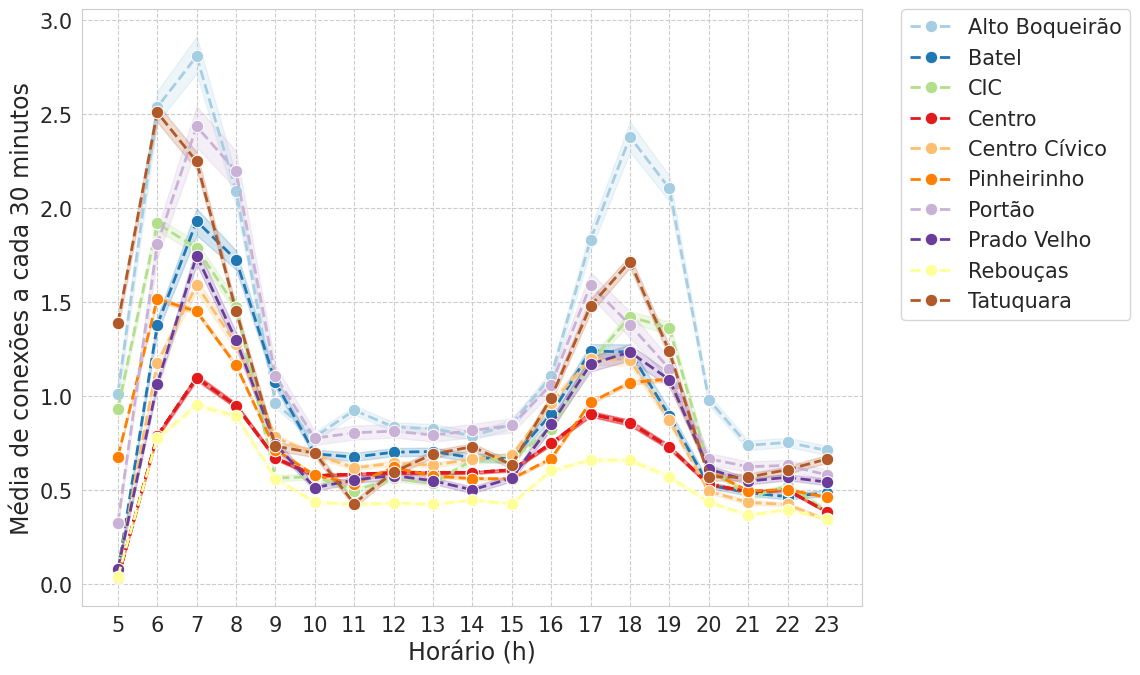

In [29]:
hue_order = list(cluster_names.values())
hue_order.sort()
fig, axes = plt.subplots(figsize = (12, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(
    x = pair_metrics.hour, y = pair_metrics.conn_count, 
    palette = sns.color_palette("Paired", len(hue_order)),
    estimator = 'mean', errorbar = ('ci', 95), hue = pair_metrics.cluster_name, hue_order = hue_order, 
    marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, ax = axes
)
g.set_xticks(range(5, 24))
g.legend(bbox_to_anchor = (1.05, 1), fontsize = 15, loc = "upper left", ncol = 1, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Horário (h)", fontsize = 17)
g.set_ylabel("Média de conexões a cada 30 minutos", fontsize = 17)
# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.75, bottom=0.1, top=0.99, wspace=0.4)
plt.savefig('avg_conn.png', format='png', dpi=300);

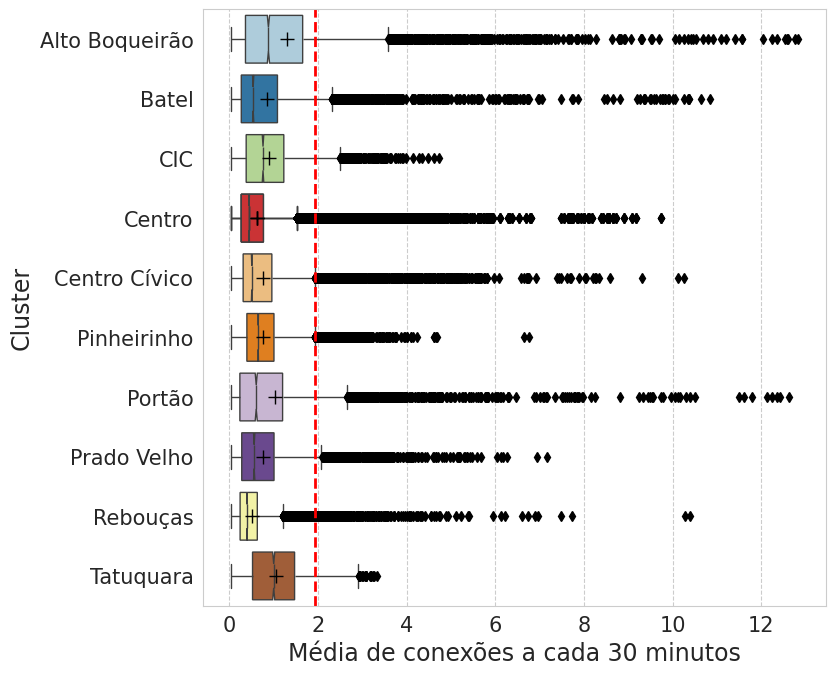

In [44]:
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(
    x = pair_metrics_day.conn_count, y = pair_metrics_day.cluster_name, 
    linewidth = 1.0, hue = pair_metrics_day.cluster_name, 
    palette = sns.color_palette("Paired", len(hue_order)), 
    notch = True, showmeans = True, order = hue_order, 
    hue_order = hue_order, 
    ax = axes, flierprops = flierprops, meanprops = meanprops)
g.tick_params(labelsize = 15)
g.set_xlabel("Média de conexões a cada 30 minutos", fontsize = 17)
g.set_ylabel("Cluster", fontsize = 17);

# Add the vertical red line at x = 2
outlier = pair_metrics_day.conn_count.describe().to_frame().transpose()

axes.axvline(x=float(outlier['75%'] + 1.5 * (outlier['75%'] - outlier['25%'])), color='red', linestyle='--', linewidth=2)

# Adjust spacing
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.1, top=0.99, wspace=0.4)
plt.savefig('boxplot_avg_conn.png', format='png', dpi=300)